# Bike Sharing Demand Dataset

## Import Library: 분석에 사용할 모듈 설치

In [182]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = 30
pd.options.display.max_columns = 20

plt.style.use("dark_background")

## Data Loading: 분석에 사용할 데이터 불러오기
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Source: https://www.kaggle.com/c/bike-sharing-demand/data

In [183]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

## Feature Engineering: 데이터에서 시계열패턴 추출하기

In [184]:
def non_feature_engineering(data):
    data = raw_data
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.set_index("datetime", drop=False)
    
    # Set frequency
    data = data.asfreq("H", method="ffill")
    
    return data

def feature_engineering(data):
    data = non_feature_engineering(raw_data)
    
    # Split dataset as Trend + Seasonal + Residual
    decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")

    y_trend = pd.DataFrame(decomp.trend)
    y_trend.columns = ["count_trend"]
    y_trend.fillna(method="ffill", inplace=True)
    y_trend.fillna(method="bfill", inplace=True)

    y_seasonal = pd.DataFrame(decomp.seasonal)
    y_seasonal.columns = ["count_seasonal"]
    y_seasonal.fillna(method="ffill", inplace=True)
    y_seasonal.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_trend, y_seasonal], axis=1)
    
    # Add moving average
    y_roll_day = data[["count"]].rolling(24).mean()
    y_roll_day.columns = ["count_day"]
    y_roll_day.fillna(method="ffill", inplace=True)
    y_roll_day.fillna(method="bfill", inplace=True)

    y_roll_week = data[["count"]].rolling(24*7).mean()
    y_roll_week.columns = ["count_week"]
    y_roll_week.fillna(method="ffill", inplace=True)
    y_roll_week.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_roll_day, y_roll_week], axis=1)
    
    # Add difference
    y_diff = data[["count"]].diff()
    y_diff.columns = ["count_diff"]
    y_diff = y_diff.fillna(method="ffill")
    y_diff = y_diff.fillna(method="bfill")
    data = pd.concat([data, y_diff], axis=1)
    
    # Add categorical variables
    data["year"] = data["datetime"].dt.year
    data["quarter"] = data["datetime"].dt.quarter
    data["quarter2"] = data["quarter"]*(data["year"] - data["year"].min() + 1)
    data["month"] = data["datetime"].dt.month
    data["day"] = data["datetime"].dt.day
    data["hour"] = data["datetime"].dt.hour
    data["dayofweek"] = data["datetime"].dt.dayofweek
    
    # Add lagged variables
    data["count_lag1"] = data["count"].shift(1)
    data["count_lag2"] = data["count"].shift(2)

    data["count_lag1"] = data["count_lag1"].fillna(method="bfill")
    data["count_lag2"] = data["count_lag2"].fillna(method="bfill")
    
    # Add dummy variables
    data = pd.concat([data, pd.get_dummies(data["quarter"], prefix="quarter_dummy", drop_first=True)], axis=1)
    data = data.drop(["quarter"], axis=1)
    
    return data

def data_split(data, crit):
    tr = data[data.index < crit]
    test = data[data.index >= crit]
    y_cols = ["count"]
    x_cols = [x for x in data.columns if x not in ["datetime", "casual", "registered"] + y_cols]
    x_tr = tr[x_cols]
    y_tr = tr[y_cols]
    x_te = test[x_cols]
    y_te = test[y_cols]
    return x_tr, y_tr, x_te, y_te

In [185]:
# plt.rcParams["figure.figsize"] = (14, 11)
# decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")
# decomp.plot()
# plt.show()

In [186]:
# decomp = sm.tsa.seasonal_decompose(data["count"], model="multiplicative")
# decomp.plot()
# plt.show()

In [187]:
# y_diff = data[["count"]].diff()
# y_diff.plot(kind="line", figsize=(20,6), linewidth=3, fontsize=20, xlim=("2012-01-01", "2012-06-01"), ylim=(-1000,1000))
# plt.show()

## Data Understanding(Getting Insight from Features)

In [188]:
# data.hist(bins=20, grid=False, figsize=(16, 16))
# plt.show()

In [189]:
# data.boxplot(column="count", by="season", grid=False, figsize=(12, 5))
# data.boxplot(column="casual", by="season", grid=False, figsize=(12, 5))
# data.boxplot(column="registered", by="season", grid=False, figsize=(12, 5))
# plt.show()

In [190]:
# data.boxplot(column="count", by="holiday", grid=False, figsize=(12, 5))
# data.boxplot(column="count", by="workingday", grid=False, figsize=(12, 5))
# plt.show()

In [191]:
# data[data.holiday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# data[data.holiday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# plt.show()

In [192]:
# data[data.workingday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# data[data.workingday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# plt.show()

In [193]:
# data.plot.scatter(y="count", x="dayofweek", c="temp", grid=False, figsize=(12, 5), cmap="RdYlBu")
# data.boxplot(column="count", by="dayofweek", grid=False, figsize=(12, 5))
# plt.show()

In [194]:
# data.boxplot(column="count", by="weather", grid=False, figsize=(12, 5))
# plt.show()

In [195]:
# pd.crosstab(index=data["count"], columns=data["weather"], margins=True)

In [196]:
# data.boxplot(column="count", by="temp", grid=False, figsize=(12, 5))
# plt.show()

In [197]:
# data.boxplot(column="count", by="humidity", grid=False, figsize=(12, 5))
# plt.show()

In [198]:
# data.boxplot(column="count", by="windspeed", grid=False, figsize=(12, 5))
# plt.show()

In [199]:
# data.boxplot(column="count", by="month", grid=False, figsize=(12, 5))
# plt.show()

In [200]:
# pd.plotting.scatter_matrix(data, figsize=(18, 18), diagonal="kde")
# plt.show()

In [201]:
# data.corr().style.background_gradient(cmap="Blues").set_precision(1).set_properties(**{"font-size":"9pt"})

In [202]:
# data.corr().loc[:, ["casual", "registered", "count"]].style.background_gradient().set_precision(2).set_properties(**{"font-size": "10pt"})

## Predict and Evaluation

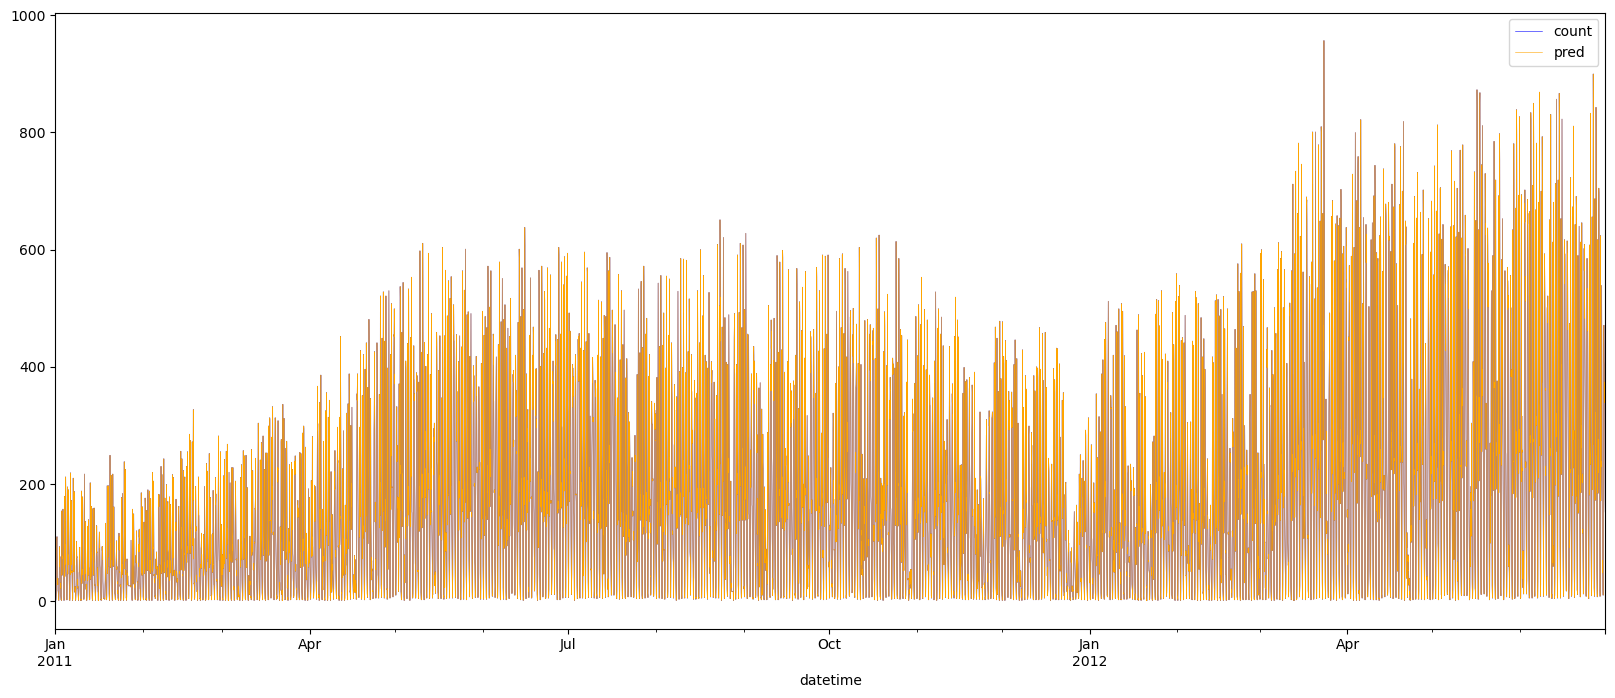

0.009 0.0438 0.0604


In [203]:
data_fe = feature_engineering(raw_data)
x_tr, y_tr, x_te, y_te = data_split(data_fe, crit="2012-07-01")
fit = sm.OLS(y_tr, x_tr).fit()
pred_tr_fe = fit.predict(x_tr).values
pred_te_fe = fit.predict(x_te).values

plt.style.use("default")
df = pd.concat([y_tr, pd.DataFrame(pred_tr_fe, index=y_tr.index, columns=["pred"])], axis=1)
df.plot.line(figsize=(20, 8), linewidth=0.4, fontsize=10, color=["blue", "orange"])
plt.show()

mae = round(abs(y_tr["count"].values - pred_tr_fe).mean(), 4)
mse = round(((y_tr["count"].values - pred_tr_fe)**2).mean(), 4)
mape = round((abs(y_tr["count"].values - pred_tr_fe)/y_tr["count"].values*100).mean(), 4)

print(mae, mse, mape)

In [204]:
# data_nfe = non_feature_engineering(raw_data)
# x_tr, y_tr, x_te, y_te = data_split(data_nfe)
# fit = sm.OLS(y_tr, x_tr).fit()
# # fit_reg1.summary()
# pred_tr_nfe = fit.predict(x_tr).values
# pred_te_nfe = fit.predict(x_te).values

# plt.style.use("default")
# df = pd.concat([y_tr, pd.DataFrame(pred_tr_nfe, index=y_tr.index, columns=["pred"])], axis=1)
# df.plot.line(figsize=(20, 8), linewidth=0.4, fontsize=10, color=["blue", "orange"])
# plt.show()
# plt.savefig("image.png", bbox_inches="tight")

# mae = round(abs(y_tr["count"].values - pred_tr_nfe).mean(), 4)
# mse = round(((y_tr["count"].values - pred_tr_nfe)**2).mean(), 4)
# mape = round((abs(y_tr["count"].values - pred_tr_nfe)/y_tr["count"].values*100).mean(), 4)

# print(mae, mse, mape)

In [205]:
resid_tr = pd.DataFrame(y_tr["count"].values - pred_tr_fe, index=y_tr.index, columns=["resid"])
resid_te = pd.DataFrame(y_te["count"].values - pred_te_fe, index=y_te.index, columns=["resid"])

## Error Analysis

## Residual Diagnostics

In [245]:
resid_tr["idx"] = resid_tr.reset_index().index

In [263]:
# Stationarity_adf Test
Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(resid_tr["resid"][1:])[0:4], index=["Test Statistic", "p-value", "Used Lag", "Used Observations"])
for key, value in sm.tsa.stattools.adfuller(resid_tr["resid"][1:])[4].items():
    Stationarity_adf[f"Critical Value({key})"] = value
Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(resid_tr["resid"][1:])[5]
Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])

In [264]:
Stationarity_adf

,Stationarity_adf
Test Statistic,-10.53
p-value,0.00
Used Lag,41.00
Used Observations,"13,085.00"
Critical Value(1%),-3.43
Critical Value(5%),-2.86
Critical Value(10%),-2.57
Maximum Information Criteria,"-106,011.75"


In [261]:
Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(resid_tr["resid"][1:])[0:3], index=["Test Statistic", "p-value", "Used Lag"])
for key, value in sm.tsa.stattools.kpss(resid_tr["resid"][1:])[3].items():
    Stationarity_kpss[f"Critical Value({key})"] = value
Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])

In [262]:
Stationarity_kpss

,Stationarity_kpss
Test Statistic,4.78
p-value,0.01
Used Lag,41.00
Critical Value(10%),0.35
Critical Value(5%),0.46
Critical Value(2.5%),0.57
Critical Value(1%),0.74


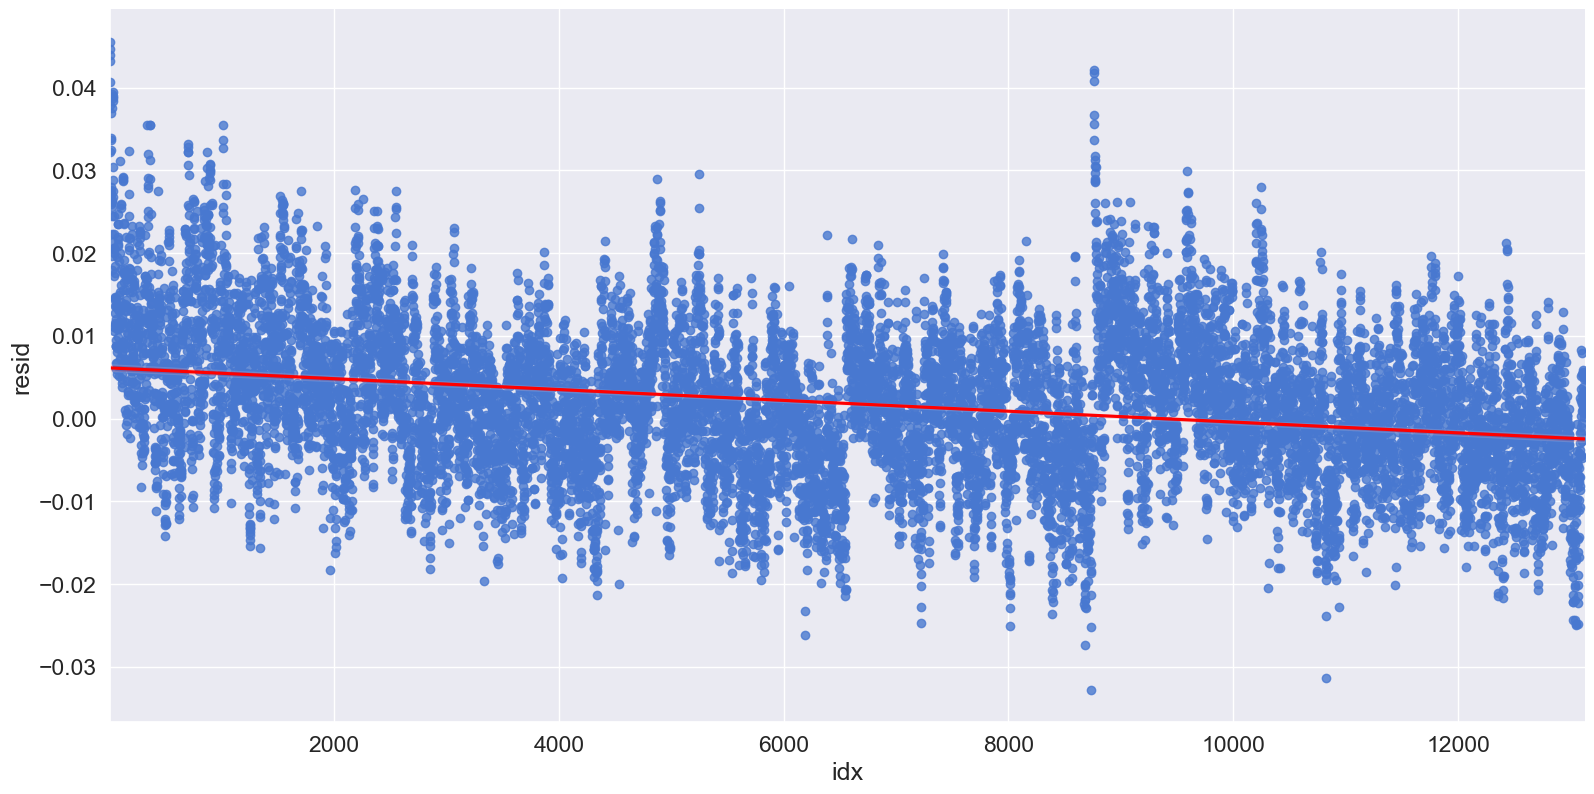

In [248]:
sb.set(palette="muted", color_codes=True, font_scale=1.5)
sb.lmplot(data=resid_tr.iloc[1:], x="idx", y="resid", fit_reg=True, line_kws={"color": "red"}, size=8, aspect=2, ci=99, sharey=True)
plt.show()

In [249]:
# Normality Test
Normality = pd.DataFrame([stats.shapiro(resid_tr["resid"][1:])], index=["Normality"], columns=["Test Statistic", "p-value"]).T

In [250]:
Normality

,Normality
Test Statistic,0.99
p-value,0.00


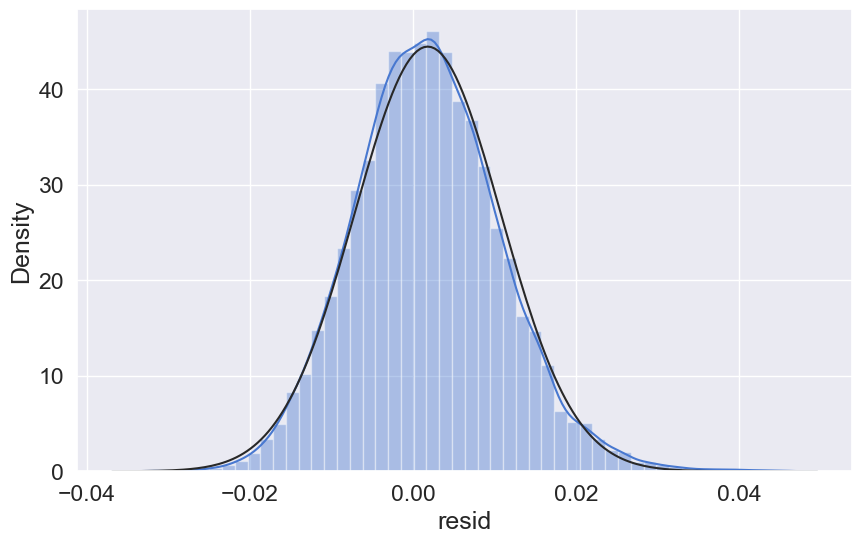

In [251]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig = sb.distplot(ax=axes, a=resid_tr["resid"].iloc[1:], norm_hist=True, fit=stats.norm)

In [252]:
# Autocorrelation Test
Autocorrelation = pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_tr["resid"][1:], lags=[1, 5, 10, 50]), index=["Test Statistic", "p-value"], columns=["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"])

In [253]:
Autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistic,"9,530.20","32,258.67","45,973.52","105,544.31"
p-value,0.00,0.00,0.00,0.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

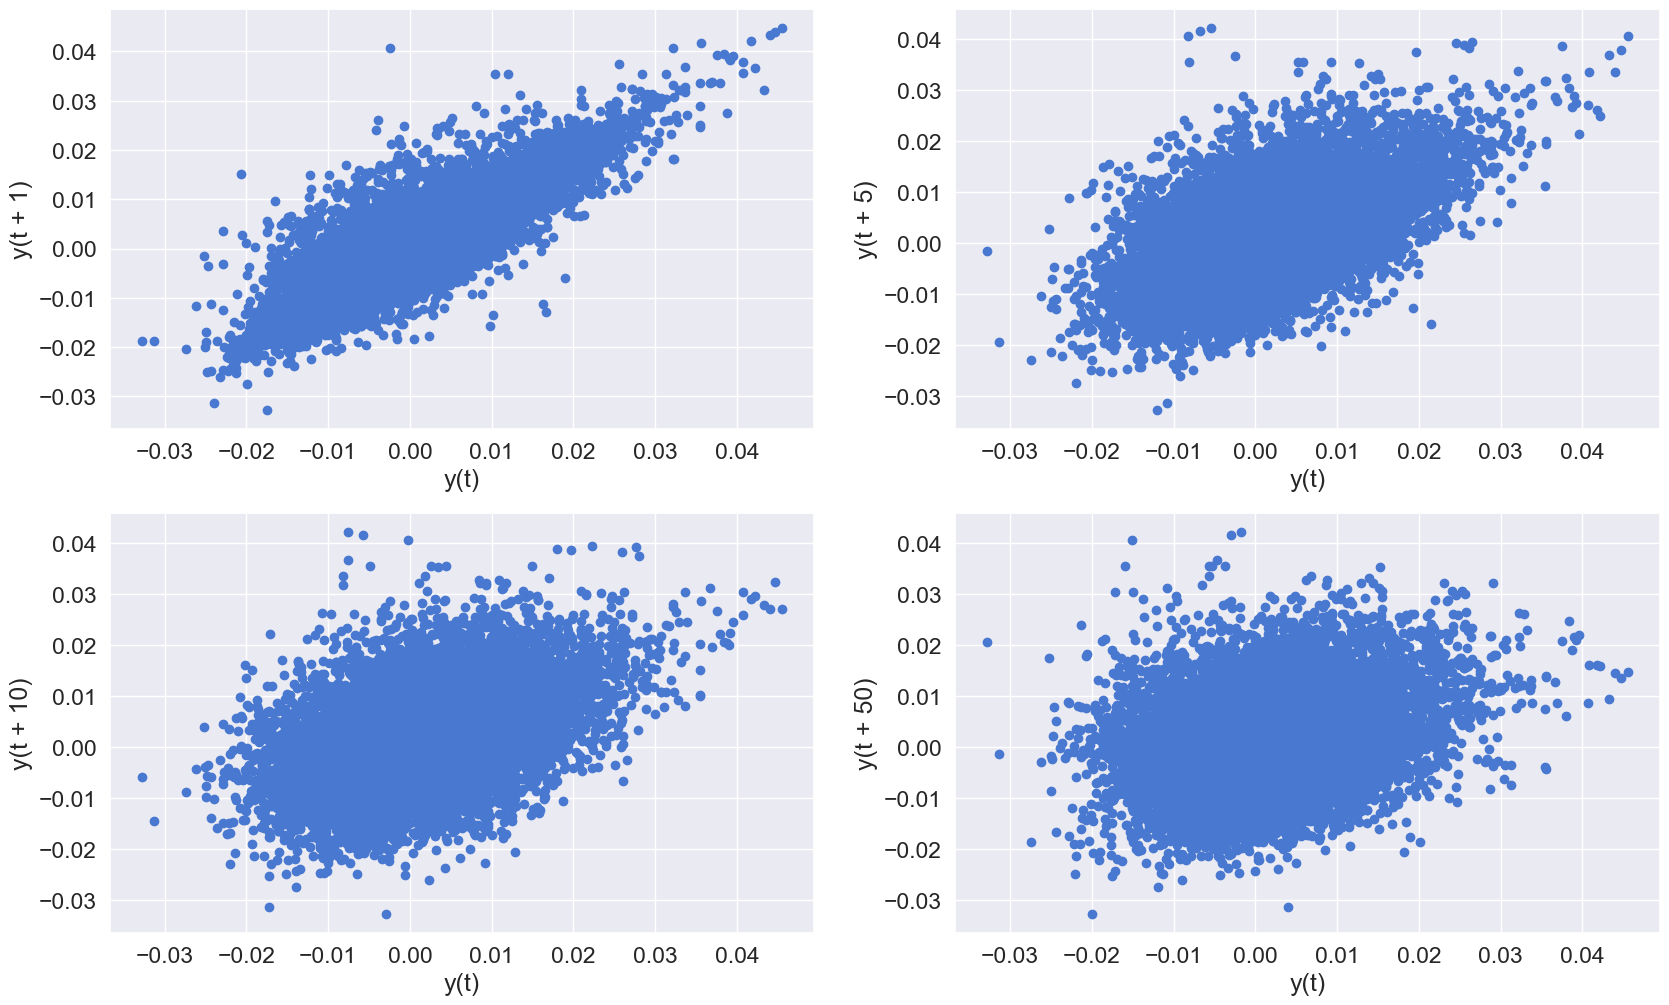

In [254]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig = pd.plotting.lag_plot(ax=axes[0][0], series=resid_tr["resid"].iloc[1:], lag=1)
fig = pd.plotting.lag_plot(ax=axes[0][1], series=resid_tr["resid"].iloc[1:], lag=5)
fig = pd.plotting.lag_plot(ax=axes[1][0], series=resid_tr["resid"].iloc[1:], lag=10)
fig = pd.plotting.lag_plot(ax=axes[1][1], series=resid_tr["resid"].iloc[1:], lag=50)

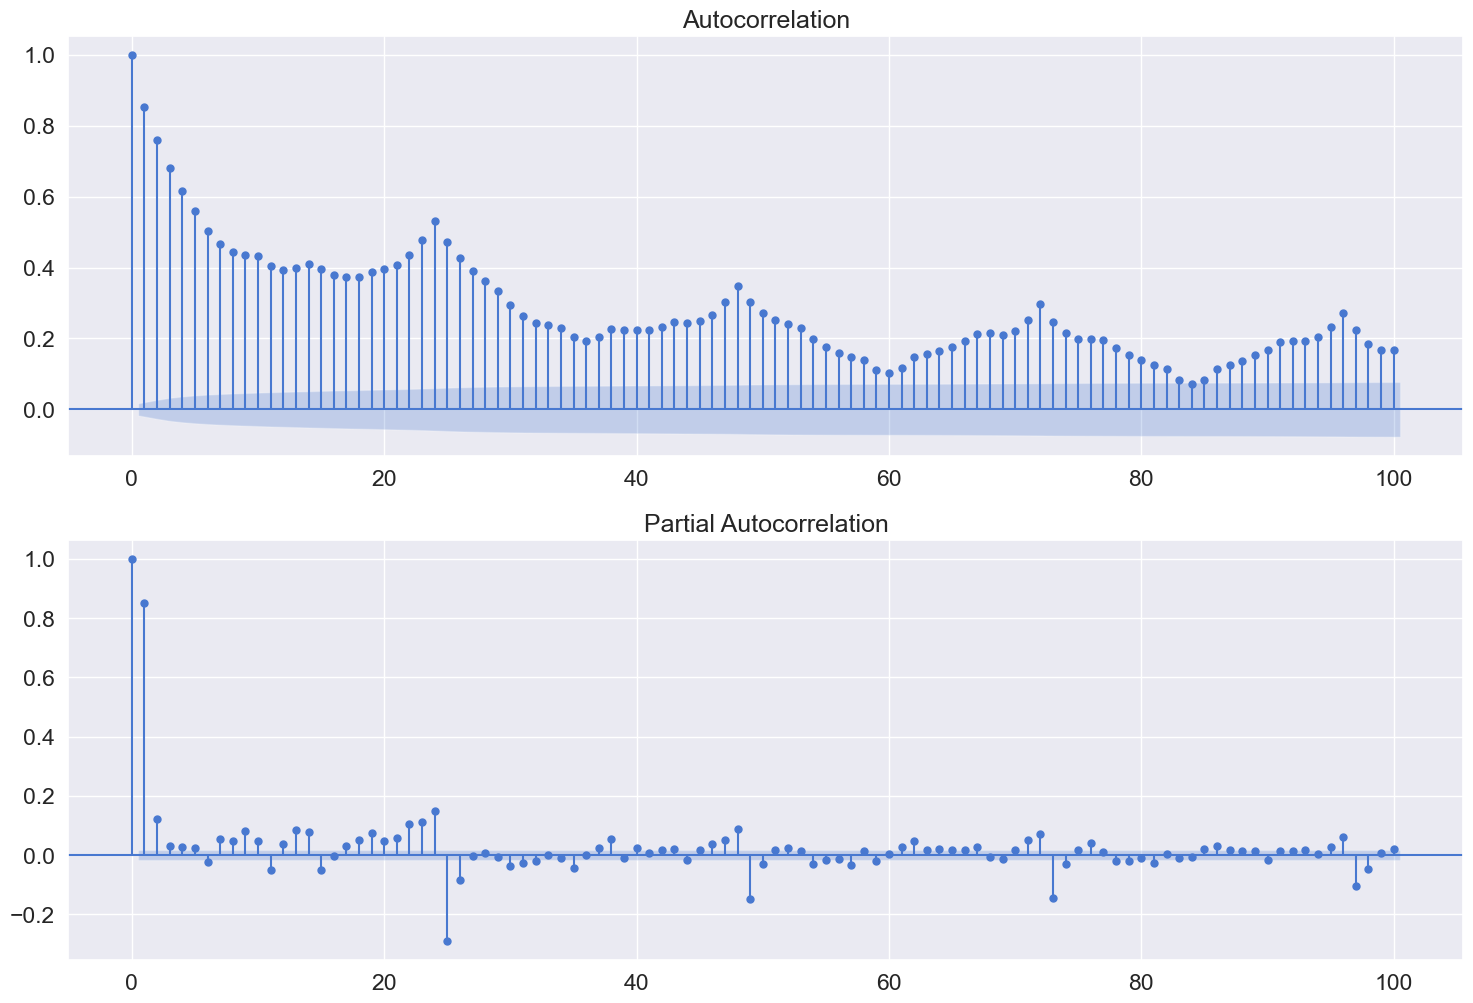

In [255]:
# Autocorrealation
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig = sm.graphics.tsa.plot_acf(ax=axes[0], x=resid_tr["resid"].iloc[1:], lags=100, use_vlines=True)
fig = sm.graphics.tsa.plot_pacf(ax=axes[1], x=resid_tr["resid"].iloc[1:], lags=100, use_vlines=True)

In [256]:
# Homoscedasticity Test
Homoscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(y=resid_tr["resid"][1:], x=x_tr.values[1:], alternative="two-sided")], index=["Homoscedasticity"], columns=["Test Statistic", "p-value", "Alternative"]).T

In [257]:
Homoscedasticity

,Homoscedasticity
Test Statistic,2.00
p-value,0.00
Alternative,two-sided


In [265]:
Error_Analysis = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Homoscedasticity], axis=1)
Error_Analysis = Error_Analysis.loc[["Test Statistic", "p-value", "Alternative", "Used Lag", "Used Observations", "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)", "Maximum Information Criteria"], :]
Error_Analysis

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Homoscedasticity
Test Statistic,-10.53,4.78,0.99,"9,530.20","32,258.67","45,973.52","105,544.31",2.00
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,085.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,0.74,nan,nan,nan,nan,nan,NaN
Critical Value(5%),-2.86,0.46,nan,nan,nan,nan,nan,NaN
Critical Value(10%),-2.57,0.35,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,011.75",nan,nan,nan,nan,nan,nan,NaN


## Code Summary

In [127]:
### Functionalize
### Error analysis
def stationarity_adf_te(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    return Stationarity_adf

def stationarity_kpss_te(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data["idx"] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sb.set(palette="muted", color_codes=True, font_scale=2)
        sb.lmplot(x="idx", y=Target_name, data=Y_Data, fit_reg="True", size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data["idx"]

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sb.distplot(Y_Data[Target_name], norm_hist="True", fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12, 5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_te(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_te(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=["Normality"], columns=["Test Statistics", "p-value"]).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=["Test Statistics"]),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=["p-value"])], axis=1).T
    Autocorrelation.columns = ["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"]

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative="two-sided")],
                                      index=["Heteroscedasticity"], columns=["Test Statistics", "p-value", "Alternative"]).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join="outer", axis=1)
    index_new = ["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                 "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)", "Maximum Information Criteria"]
    Score.reindex(index_new)
    return Score
# error_analysis(resid_tr[1:], ["resid"], X_train, graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


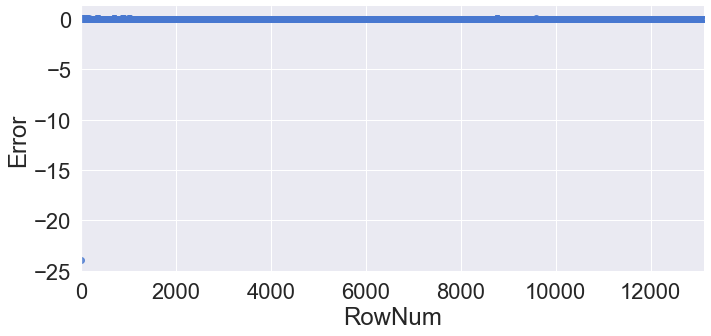

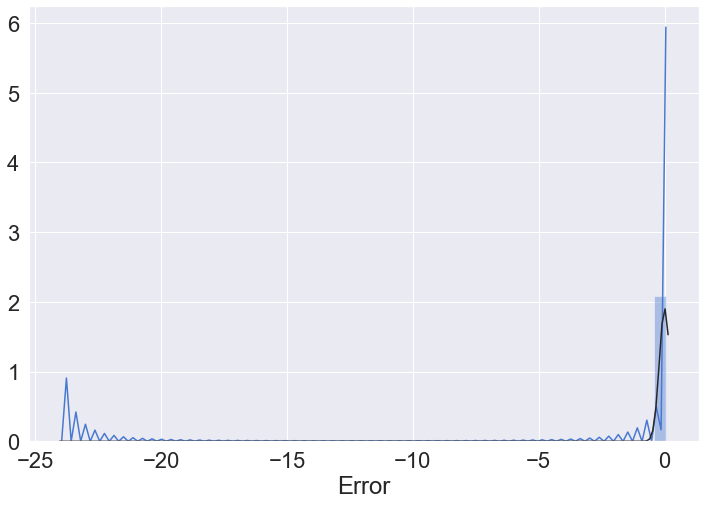

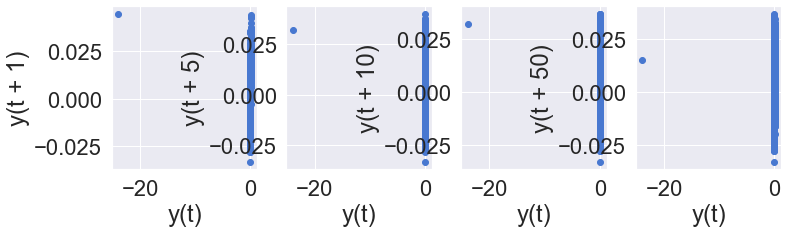

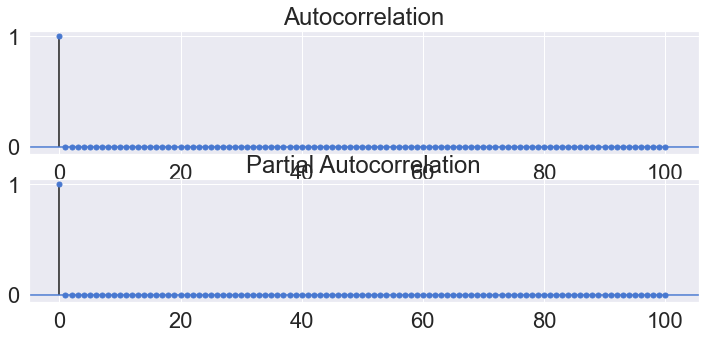

In [128]:
error_analysis(resid_tr, ["resid"], X_train, graph_on=True)
# 정상성 / 비정규분포 / 자기상관없음 / 등분산아님

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.82,7.52,1.00,"9,615.96","32,903.39","47,262.88","116,653.97",2.10
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,085.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,838.93",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


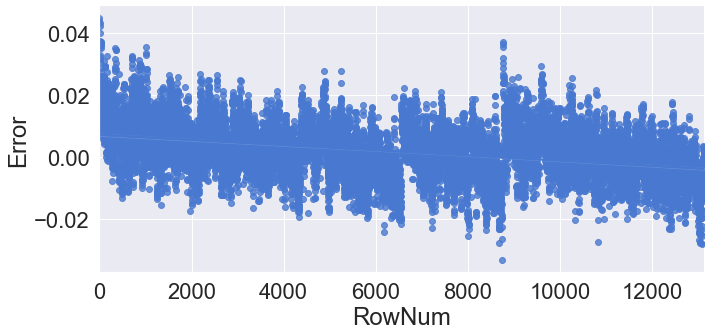

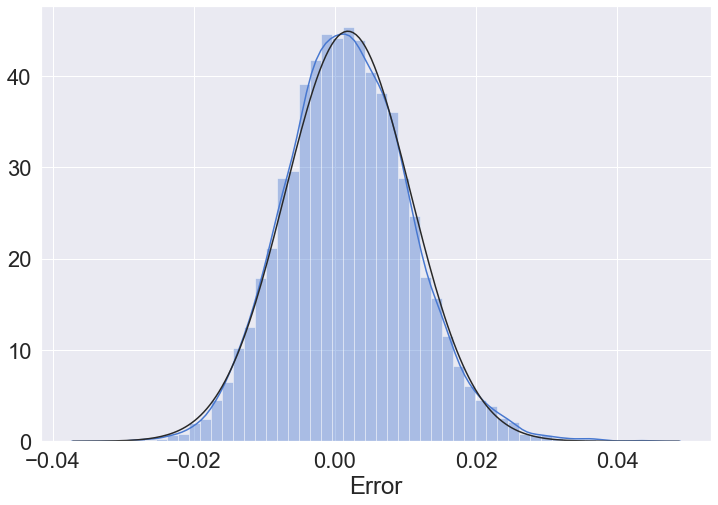

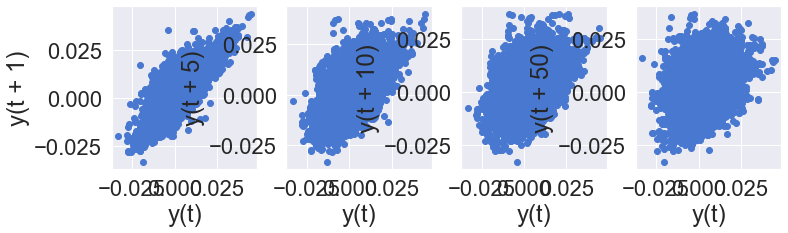

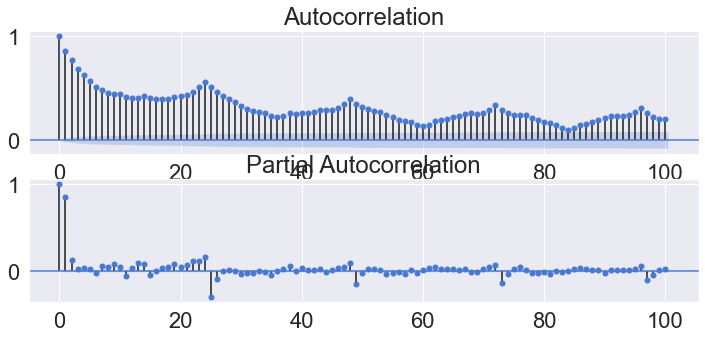

In [129]:
error_analysis(resid_tr.iloc[1:], ["resid"], X_train, graph_on=True)
# 정상성(ADf) / 비정상성(KPSS) / 비정규분포 / 자기상관있음 / 등분산아님